In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# 1. Load data from Excel
df = pd.read_excel("/Users/marclambertes/Python/Matches/Women/2024-2025/Leagues - Project/Pass/Netherlands - Pass.xlsx")

# 2. Exclude rows where Corner == 1, FK == 1, or ThrowIn == 1
df = df[~((df["Corner"] == 1) | (df["FK"] == 1) | (df["ThrowIn"] == 1))]

# 3. Add calculated features
df["distance_to_goal"] = np.sqrt((105 - df["endX"])**2 + (34 - df["endY"])**2)
df["angle_to_goal"] = np.arctan2(34 - df["endY"], 105 - df["endX"])

# 4. Encode targets based on rules
df["goal"] = (df["typeId"] == 16).astype(int)
df["loss"] = (df["typeId"] == 9).astype(int)
df["possession_continuation"] = ((df["typeId"] == 1) & (df["outcome"] == 1)).astype(int)

# 5. Additional encoded columns
df["TakeO"] = (df["typeId"] == 3).astype(int)
df["Shot"] = ((df["typeId"] == 13) | (df["typeId"] == 14) | (df["typeId"] == 15)).astype(int)
df["Tackle"] = ((df["typeId"] == 7) & (df["outcome"] == 1)).astype(int)
df["Ball_recovery"] = (df["typeId"] == 49).astype(int)
df["Assists"] = (df["Assist"] == 1).astype(int)
df["2nd_Assists"] = (df["2nd Assist"] == 1).astype(int)

# 6. Define features and targets
features = [
    "x", "y", "endX", "endY", 
    "distance_to_goal", "angle_to_goal",
    "TakeO", "Shot", "Tackle", "Ball_recovery", 
    "Assists", "2nd_Assists"
]
targets = [
    "goal", "possession_continuation", "loss",
    "TakeO", "Shot", "Tackle", 
    "Ball_recovery", "Assists", "2nd_Assists"
]

# 7. Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[targets], test_size=0.2, random_state=42
)

# 8. Train RandomForest models for each outcome
models = {}
for target in targets:
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train[target])
    models[target] = clf

# 9. Predict probabilities using multiple simulations for stability
n_simulations = 1000
probs = {target: np.zeros(len(X_test)) for target in targets}

for _ in range(n_simulations):
    for target in targets:
        if len(models[target].classes_) == 1:
            # Single-class case
            probs[target] += 0
        else:
            # Accumulate probabilities for class==1
            probs[target] += models[target].predict_proba(X_test[features])[:, 1]

# 10. Average the probabilities over the simulations
for target in targets:
    probs[target] /= n_simulations
    # Store them in X_test
    X_test[f"{target}_prob"] = probs[target]

# 11. Define weights for each metric's contribution to EPV
weights = {
    "goal_prob": 1.5,
    "loss_prob": -1.0,
    "possession_continuation_prob": 0.8,
    "TakeO_prob": 0.5,
    "Shot_prob": 1.2,
    "Tackle_prob": 0.4,
    "Ball_recovery_prob": 0.6,
    "Assists_prob": 1.0,
    "2nd_Assists_prob": 0.7
}

# 12. Calculate a weighted EPV
X_test["epv"] = sum(
    weights[f"{target}_prob"] * X_test[f"{target}_prob"]
    for target in targets
)

# 13. Merge the epv (and probabilities) back into df
#     Initialize columns in df so we can fill them in
for target in targets:
    df[f"{target}_prob"] = np.nan
df["epv"] = np.nan

# Update rows that are part of X_test
df.loc[X_test.index, "epv"] = X_test["epv"]
for target in targets:
    df.loc[X_test.index, f"{target}_prob"] = X_test[f"{target}_prob"]

# 14. Create a final DataFrame of columns in the desired order
final_columns = [
    "playerName",  # Add playerName to ensure uniqueness
    "goal_prob",
    "possession_continuation_prob",
    "loss_prob",
    "TakeO_prob",
    "Shot_prob",
    "Tackle_prob",
    "Ball_recovery_prob",
    "Assists_prob",
    "2nd_Assists_prob",
    "epv",
]
final_df = df[final_columns].copy()  # This includes all rows (for all players)

# 15. Save to a single Excel file
output_filename = "AllPlayers_Probabilities_and_EPV.xlsx"
final_df.to_excel(output_filename, index=True)  # keep the original row indices

print(f"Saved final table to '{output_filename}'. Here is a preview:")
print(final_df.head(10))

# Ensure 'playerName' is treated as a string and handle NaN values
df["playerName"] = df["playerName"].fillna("Unknown").astype(str)

# Save separate files for each unique player with unique playerName and probabilities
unique_players = df["playerName"].unique()

for player in unique_players:
    player_df = df[df["playerName"] == player]
    player_final_df = player_df[["playerName"] + final_columns[1:]].drop_duplicates(subset="playerName").copy()

    # Construct a filename for each player
    player_filename = f"{player.replace(' ', '_')}_Probabilities_and_EPV.xlsx"

    # Save the player's data to an Excel file
    player_final_df.to_excel(player_filename, index=False)  # exclude the index for clean output

    print(f"Saved probabilities and EPV table for player '{player}' to '{player_filename}'.")

# 16. Calculate totals per player for all actions
totals_per_player = df.groupby("playerName")[
    ["goal", "loss", "possession_continuation", "TakeO", "Shot", "Tackle", "Ball_recovery", "Assists", "2nd_Assists"]
].sum().reset_index()

# 17. Merge totals with probabilities and EPV
merged_df = pd.merge(final_df, totals_per_player, on="playerName", how="left")

# Save the merged data to a single Excel file
merged_filename = "AllPlayers_Combined_Probabilities_Totals_and_EPV.xlsx"
merged_df.to_excel(merged_filename, index=False)

print(f"Saved combined data for all players to '{merged_filename}'. Here is a preview:")
print(merged_df.head())


Saved final table to 'AllPlayers_Probabilities_and_EPV.xlsx'. Here is a preview:
    playerName  goal_prob  possession_continuation_prob  loss_prob  \
0          NaN        NaN                           NaN        NaN   
1          NaN        NaN                           NaN        NaN   
2          NaN        NaN                           NaN        NaN   
3          NaN        NaN                           NaN        NaN   
4       G. Til        0.0                          1.00        0.0   
5   J. Veerman        NaN                           NaN        NaN   
6   M. Tillman        0.0                          0.97        0.0   
7  O. Boscagli        NaN                           NaN        NaN   
8      M. Dams        NaN                           NaN        NaN   
9  O. Boscagli        NaN                           NaN        NaN   

   TakeO_prob  Shot_prob  Tackle_prob  Ball_recovery_prob  Assists_prob  \
0         NaN        NaN          NaN                 NaN           NaN  

Saved probabilities and EPV table for player 'J. Houwen' to 'J._Houwen_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'Visus' to 'Visus_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'O. Zawada' to 'O._Zawada_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'J. Familia-Castillo' to 'J._Familia-Castillo_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'D. Van den Buijs' to 'D._Van_den_Buijs_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'R. van Eijma' to 'R._van_Eijma_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'G. Roemeratoe' to 'G._Roemeratoe_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'L. Delaurier-Chaubet' to 'L._Delaurier-Chaubet_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'D. Weidmann' to 'D._Weidmann_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table 

Saved probabilities and EPV table for player 'J. Lelieveld' to 'J._Lelieveld_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'S. Podgoreanu' to 'S._Podgoreanu_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'J. Hornkamp' to 'J._Hornkamp_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'M. Kramer' to 'M._Kramer_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'M. Ihattaren' to 'M._Ihattaren_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'J. Hoogma' to 'J._Hoogma_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'I. Saibari' to 'I._Saibari_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'I. Perišić' to 'I._Perišić_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'Hugo Bueno' to 'Hugo_Bueno_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'D. Hancko' to 'D._Hancko

Saved probabilities and EPV table for player 'A. Obispo' to 'A._Obispo_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'O. Velanas' to 'O._Velanas_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'J. Toornstra' to 'J._Toornstra_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'Zidane Iqbal' to 'Zidane_Iqbal_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'M. van der Hoorn' to 'M._van_der_Hoorn_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'Miguel Rodríguez' to 'Miguel_Rodríguez_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'Y. Cathline' to 'Y._Cathline_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'S. El Karouani' to 'S._El_Karouani_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'P. Aaronson' to 'P._Aaronson_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for pl

Saved probabilities and EPV table for player 'B. Pereira' to 'B._Pereira_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'S. Ouaissa' to 'S._Ouaissa_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'M. Köhlert' to 'M._Köhlert_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'B. Nuytinck' to 'B._Nuytinck_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'K. Sano' to 'K._Sano_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'R. Roefs' to 'R._Roefs_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'Iván Márquez' to 'Iván_Márquez_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'M. Hoedemakers' to 'M._Hoedemakers_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'T. Ouwejan' to 'T._Ouwejan_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'K. Ogawa' to 'K._Ogawa_Probabili

Saved probabilities and EPV table for player 'K. Smit' to 'K._Smit_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'Kayky' to 'Kayky_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'M. van Brederode' to 'M._van_Brederode_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'R. Bazoer' to 'R._Bazoer_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'T. de Jonge' to 'T._de_Jonge_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'D. Dankerlui' to 'D._Dankerlui_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'G. Beaumont' to 'G._Beaumont_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'P. van Aanholt' to 'P._van_Aanholt_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'L. Everink' to 'L._Everink_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'A. Kaied' to 'A._Kaied_Pro

FileCreateError: [Errno 28] No space left on device

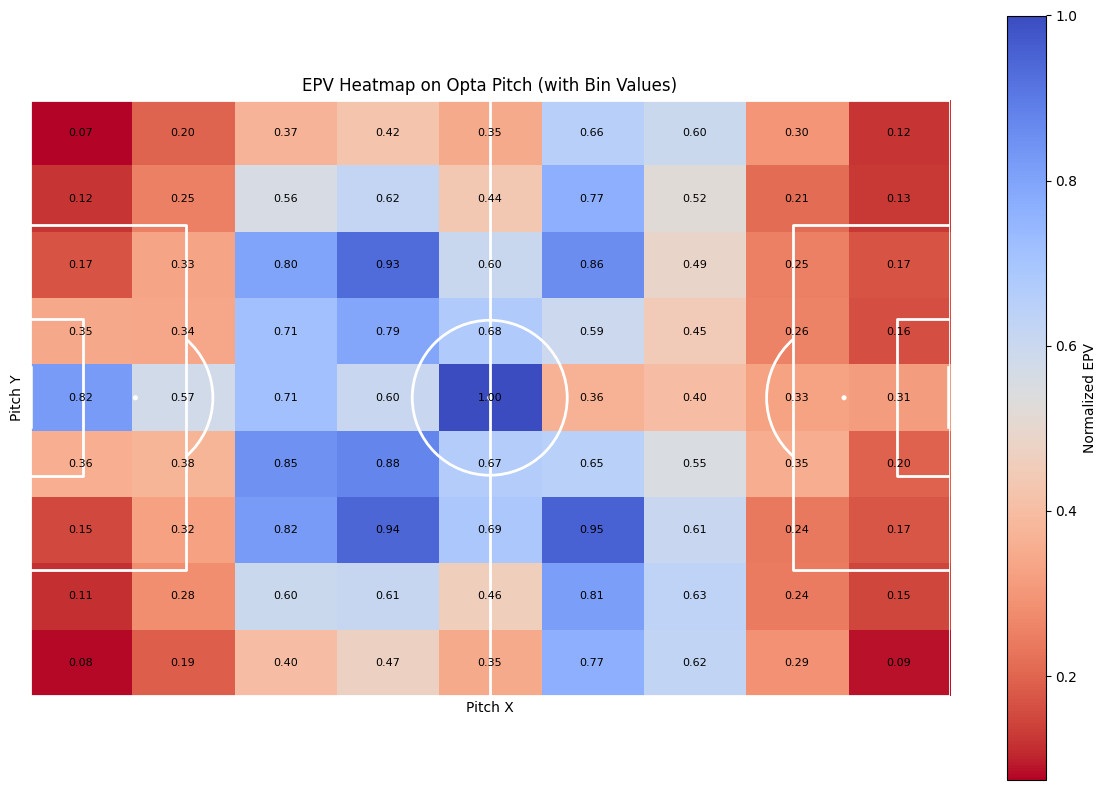

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Define grid size and bins for pitch areas (split pitch into smaller cells)
grid_size = 10  # Adjust the grid size if needed
x_bins = np.linspace(0, 100, grid_size)  # Opta pitch width (scaled to 100)
y_bins = np.linspace(0, 100, grid_size)  # Opta pitch height (scaled to 100)

# Calculate the 2D histogram of EPV values based on the position of the event's end (end_x, end_y)
# Note that X_test["y"] corresponds to the height (y), and X_test["x"] corresponds to the width (x)
heatmap, xedges, yedges = np.histogram2d(
    X_test["x"], X_test["y"], bins=[x_bins, y_bins], weights=X_test["epv"]
)

# Normalize the heatmap to a 0-1 range for better color mapping
heatmap = heatmap / np.max(heatmap)

# Create a Pitch object with Opta pitch layout
pitch = Pitch(pitch_type='opta', pitch_color='green', line_color='white')

# Create the figure and axis with constrained layout
fig, ax = pitch.draw(figsize=(12, 8), constrained_layout=True)

# Plot the heatmap using imshow for better aspect control
im = ax.imshow(
    heatmap.T,          # Transpose so rows=Y, columns=X for imshow
    cmap="coolwarm_r",  # Reversed color map: warmer colors for higher values
    extent=[0, 100, 0, 100],  # Match the Opta pitch bounds (0-100 for x and y)
    origin="lower",     # Ensure the origin starts from the bottom-left
)

# Adjust the aspect ratio manually to reflect a football pitch's dimensions (105x68)
ax.set_aspect(68 / 105)  # y-axis (height) will correspond to the 105m width

# Adjust the x and y axis limits to match the pitch dimensions
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# Reverse the y-axis to match the typical football pitch view
ax.invert_yaxis()
# ax.invert_xaxis()  # Uncomment if you want to flip horizontally as well

# Annotate each bin with its EPV value
# heatmap.shape = (len(x_bins)-1, len(y_bins)-1)
# i corresponds to x-bins, j to y-bins
for i in range(len(xedges) - 1):
    for j in range(len(yedges) - 1):
        # Calculate bin center
        x_center = (xedges[i] + xedges[i + 1]) / 2
        y_center = (yedges[j] + yedges[j + 1]) / 2
        
        # Get the EPV value from the heatmap
        # Note: Because of the transpose in imshow, we index heatmap as [i, j]
        val = heatmap[i, j]
        
        # Optionally skip printing zero or very small values
        # if val < 0.001:
        #     continue
        
        # Add text at the center of the bin
        ax.text(
            x_center, y_center,
            f"{val:.2f}",         # Round to 2 decimal places
            color="black",        # Choose 'white' or 'black' depending on visibility
            ha="center", va="center", fontsize=8
        )

# Add title and labels
plt.title("EPV Heatmap on Opta Pitch (with Bin Values)")
plt.xlabel("Pitch X")
plt.ylabel("Pitch Y")

# Show the colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical')
cbar.set_label("Normalized EPV")

# Show the plot
plt.show()


In [8]:
# Calculate totals for every player
totals = merged_df.groupby("playerName")[
    [
        "goal_prob",
        "possession_continuation_prob",
        "loss_prob",
        "TakeO_prob",
        "Shot_prob",
        "Tackle_prob",
        "Ball_recovery_prob",
        "Assists_prob",
        "2nd_Assists_prob",
        "epv",
    ]
].sum().reset_index()

# Save totals to a new Excel file
totals_filename = "AllPlayers_Totals_Probabilities_and_EPV.xlsx"
totals.to_excel(totals_filename, index=False)

print(f"Saved total probabilities and EPV for all players to '{totals_filename}'. Here is a preview:")
print(totals.head())


Saved total probabilities and EPV for all players to 'AllPlayers_Totals_Probabilities_and_EPV.xlsx'. Here is a preview:
     playerName  goal_prob  possession_continuation_prob  loss_prob  \
0  A. Adelgaard       0.00                         28.37        0.0   
1      A. Blake       0.00                          4.60        0.0   
2      A. Condé       0.00                         42.53        0.0   
3    A. Darelas       0.00                          1.39        0.0   
4   A. Descotte       0.01                          7.22        0.0   

   TakeO_prob  Shot_prob  Tackle_prob  Ball_recovery_prob  Assists_prob  \
0         1.0        0.0          4.0                 4.0          0.06   
1         0.0        0.0          0.0                 0.0          0.03   
2         0.0        0.0          0.0                 3.0          0.98   
3         0.0        0.0          0.0                 0.0          0.00   
4         0.0        3.0          0.0                 0.0          0.01   

  

In [9]:
import pandas as pd

# Create a DataFrame to store grid data
grid_data = []

for i in range(len(xedges) - 1):
    for j in range(len(yedges) - 1):
        # Calculate bin center
        x_center = (xedges[i] + xedges[i + 1]) / 2
        y_center = (yedges[j] + yedges[j + 1]) / 2
        
        # Get the EPV value from the heatmap
        val = heatmap[i, j]
        
        # Append to grid data
        grid_data.append({
            "x_center": x_center,
            "y_center": y_center,
            "epv": val
        })

# Convert grid data to a DataFrame
grid_df = pd.DataFrame(grid_data)

# Save the DataFrame to CSV
grid_df.to_csv("epv_grid.csv", index=False)
print("EPV grid saved to epv_grid.csv")


EPV grid saved to epv_grid.csv
